We'll be using Long Short Term Memory, or LSTM, machine learning model to predict the stock price of a company of your choice.

In [ ]:
# import necessary packages
import math
import yfinance
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# import tensorflow
# import Pytorch
from keras.models import Sequential # this is for ML models that process data sequentially, and not "jumping around" or "going back and forth" and such
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Setup for nicer visualization
plt.style.use('fivethirtyeight')

# NSDC Spring 2024 Project

In the above, we imported packages we will be using throughout this project and modified the visualization a little bit.

Here, I make some short descriptions of each packages that I've imported. If you already have experience in Python, you may already know these:

- math is a package used to do ... math.
- yfinance is a package to get financial data from yahoo finance. This is the package we will use to get stock market prices.
- numpy, one of the most well known Python package, is used for efficient manipulation of data. numpy is adopted for many other packages, like matplotlib for data visualization, and pandas for processing tabular data.
- sklearn.preprocessing has various tools allowing us to transform our data, e.g. MinMaxScalar and StandardScaler. It's part of the package sklearn, which stands for "SciPy Toolkit learn" where "SciPy" is for "Scientific Python" or its like.
- keras is a package that is popular for machine learning. It's also integrated as part of the tensorflow package, one of the most popular machine learning machine learning framework along with PyTorch, but we will use keras as a standalone here.
- matplotlib is a package for data visualization.

In [ ]:
# Download stock market data as DataFrame
# start here ---------------------
# import the data of a company of your choice

df = yfinance.download('TSLA', start='2012-01-01', end='2024-05-08', progress = False)

# end here -----------------------



# display the result
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
2012-01-04,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2012-01-05,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
2012-01-06,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
2012-01-09,1.800000,1.832667,1.741333,1.816667,1.816667,13455000
...,...,...,...,...,...,...
2024-05-01,182.000000,185.860001,179.009995,179.990005,179.990005,92829700
2024-05-02,182.860001,184.600006,176.020004,180.009995,180.009995,89148000
2024-05-03,182.100006,184.779999,178.419998,181.190002,181.190002,75491500


Notice that, if the company of your choice was not being publically traded on the start date, your dataset will begin from the day it began to be publically traded, or some date close to that. You can check how many rows and columns your data has by typing `df.shape`.

Also, notice that the stock market data has various features, i.e. the opening stock market price, the closing stock market price, the highest and the lowest stock market price of each day, and the volume of stocks traded. We'll focus our attention on the closing stock market prices, as we shall impliment in code later.

In [ ]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

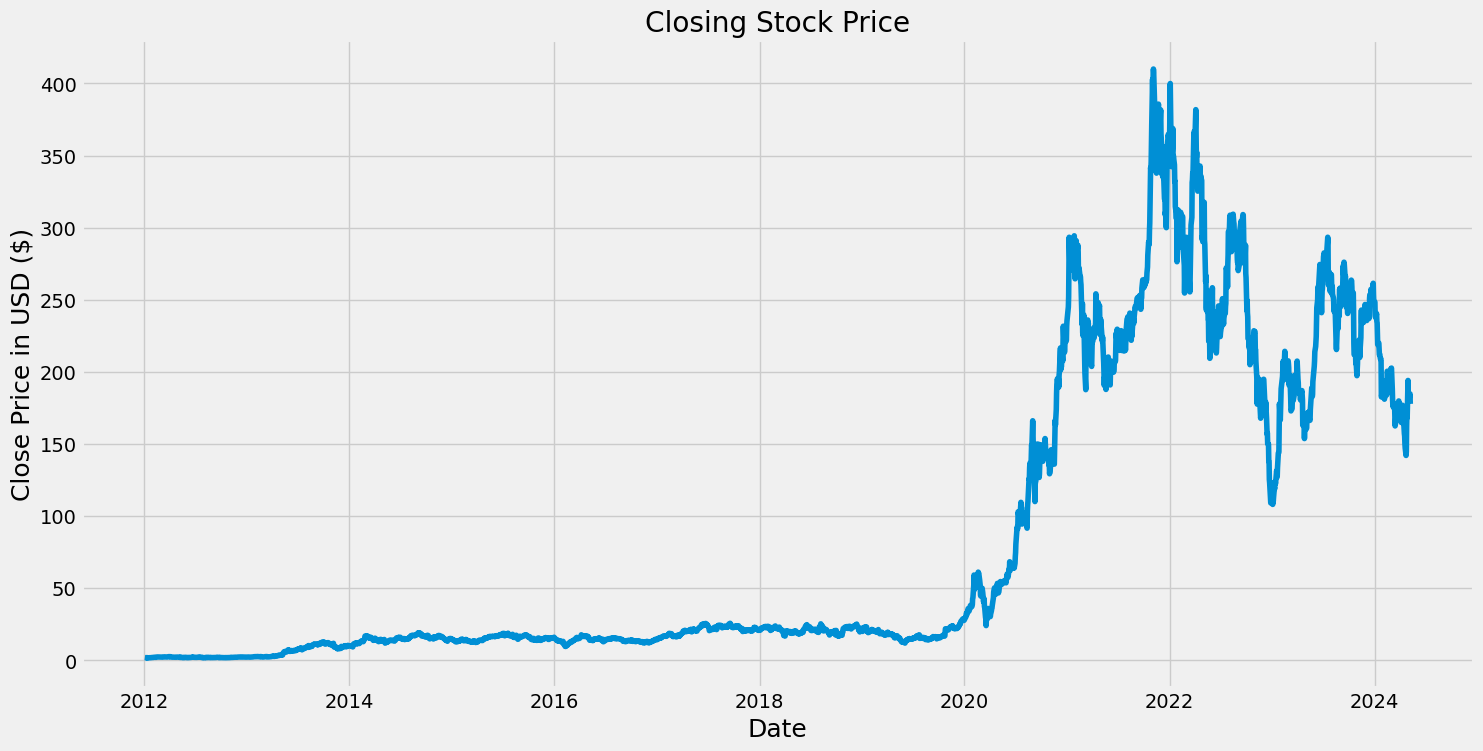

In [ ]:
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Stock Price')
plt.plot(data)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in USD ($)', fontsize=18)
plt.show()

We now convert our data into a numpy array. The reason is that our LSTM model later will not accept a pandas.DataFrame object as its input.

In [ ]:
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

print(f"The number of rows we shall use for training is {training_data_len}.")


The number of rows we shall use for training is 2485.


Now we will scale our data. The reason is that this will make our Machine Learning (ML) model training much more efficient.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
# StadardScaler() after "from sklearn.preprocessing import StandarsScaler()"
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00086343],
       [0.00080303],
       [0.00070674],
       ...,
       [0.4398834 ],
       [0.44862373],
       [0.43160822]])

Now that we have scaled our data, we will define our training set suitable for use for our LSTM model.

In [ ]:
# The number of days with stock market prices that LSTM model will "look back" on
num_days_look_back = 60

# Create the scaled training dataset
train_data = scaled_data[0: training_data_len, :]
# Split the data into x_train and y_train dataset
x_train = []
y_train = []
for i in range(num_days_look_back, len(train_data)):
  x_train.append(train_data[i- num_days_look_back:i, 0])
  y_train.append(train_data[i,0])
# display example values
  if i <= num_days_look_back + 1:
    print(x_train)
    print(y_train)
    print()

[array([0.00086343, 0.00080303, 0.00070674, 0.00067246, 0.00072796,
       0.00078834, 0.00088791, 0.00089117, 0.        , 0.00062186,
       0.00065614, 0.00064798, 0.00062186, 0.00064961, 0.0007557 ,
       0.00084547, 0.00100379, 0.00106745, 0.00110662, 0.00102501,
       0.00110825, 0.00121761, 0.00136451, 0.0014706 , 0.00143796,
       0.00149182, 0.00159791, 0.00135634, 0.00142   , 0.00169421,
       0.00176439, 0.00185906, 0.001988  , 0.00191129, 0.00186559,
       0.00191618, 0.00178887, 0.00176766, 0.00179867, 0.00173338,
       0.0018966 , 0.00183621, 0.00179214, 0.00168441, 0.00168605,
       0.00167789, 0.00195046, 0.00215775, 0.00217081, 0.00204023,
       0.0019929 , 0.00204513, 0.00198963, 0.00198637, 0.00201738,
       0.00189497, 0.00184274, 0.00238462, 0.00247276, 0.00245807])]
[0.0023731972591546557]

[array([0.00086343, 0.00080303, 0.00070674, 0.00067246, 0.00072796,
       0.00078834, 0.00088791, 0.00089117, 0.        , 0.00062186,
       0.00065614, 0.00064798, 0.

Great! We now have training data. Again, our LSTM model is pretty picky in the data type of objects it accepts. For this reason, we will convert our training dataset to numpy arrays.

In [ ]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

Another thing: our LSTM model is picky not only in datatype, but also in the dimension (i.e. `shape`) of its input. So we'll also make a small change like so:

In [ ]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2425, 60, 1)

Here is the main crux of this project. In the cell below, you will build an LSTM model of your choice. It will be insightful to experient with differnt hyperparameters, such as:

- number of hidden layers
- number of neurons (i.e. `units`) in each layer
- types of layers. Here, you may choose `LSTM` layer, a fully connected layer (i.e. a `Dense` layer, which is called so because all the nuerons are "densely" connected), etc. There are other layers that you can explore also, such as:
  - `Dropout` layer, which is a type of regularization which has somewhat similar effect of L2 or L1 regularization. Drops out a random subset of neurons of a single layer when we do gradient descent.
  - `BatchNormalization` layer, which normalizes the activations previous layer (i.e. the outputs of previous layer). In other words, batch normalization is applying z-score normalization to the activations of previous layer.
- hyperparameters, such as:
  - the percentage of neurons dropped out by the `Dropout` layer, e.g. a = 0.1 or 0.2 in `Dropout(a)`. `Dropout(0.2)` will drop out 20% of the neurons of the layer that comes before it.

Now, how did I come up with the structure of my own model? I just experimented with different model structures / parameters until I found one that works better than others I have tried. That being said, the more layers and units you add, in general the more complex your model will be, but also more prone to overfitting, and the more time it will take to train.

In [ ]:
# start here --------------
# Build your own LSTM model



# end here ---------------

#Build the LSTM model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# The above can also be written in the following form as follows, which gives exactly the same result as above:
model = Sequential([
    LSTM(units = 32, return_sequences=True, input_shape = (x_train.shape[1], 1)),
    LSTM(units = 32, return_sequences=True),
    LSTM(units = 32, return_sequences=True),
    LSTM(units = 32, return_sequences=False),
    Dense(units = 25),
    Dense(units = 1)
])

the `return_sequences=True` is needed for all LSTM layers except the last LSTM layer, just so that the output of a previous LSTM layer matches the input shape and type of the LSTM layer that comes after it. Also, you can actually skip writing `units =` for every layer; writing `units =` is optional. Also, notice that `unit = 1` for last layer will produce an error, i.e. it has to have `s` at the end of `unit` even if we only have 1 neuron.

Great! Now you have constructed your model. Now we just need to specify what optimizer to use and what will be our loss function, so that the computer knows precisely what to do for running gradient descent:

In [ ]:
# import different optimizers
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Nadam

# start here ----------------
# compile your model



# end here ------------------


# Set the learning rate
learning_rate = 0.01

# Create the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

Feel free to experiment with different optimizers, i.e. set `optimizer` as,:
 - For Stochastic Gradient Descent, `SGD(learning_rate=0.01, momentum=0.9)`;
 - For RMSprop, `RMSprop(learning_rate=0.001)`;
 - For Adagrade, `Adagrad(learning_rate=0.01)`;
 - For Adadelta, `Adadelta(learning_rate=0.01)`;
 - For Adam RMSprop with Nesterov momentum, `Nadam(learning_rate=0.002)`;

where each `learning_rate` (and, for SGD, `momentum`), is a hyperparameter you can also change.

Now it's time for you to train the model! Below will take a few minutes to run.

In [ ]:
# start here -----------
# Train the model


# end here -------------


# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2425/2425 [==============================] - 138s 54ms/step - loss: 0.0217
Epoch 2/3
2425/2425 [==============================] - 128s 53ms/step - loss: 0.0336
Epoch 3/3
2425/2425 [==============================] - 129s 53ms/step - loss: 0.0331


In the above, `batch_size` and `epochs` are also hyperparameters you can change. If you are curious, I will be glad to tell you what each of these mean in the next meeting :)

Notice that running the above with large number of epochs will result in a really long running time (`ETA` stands for "Estimated Time Arrival" to our 'destination' of the end of the epoch). If you did wait for such a long time, you now know why a hardware with high computation power, like GPU, is useful for machine learning: our regular laptop runs very slowly for training even a small to moderately sized ML model.

Similar to how we defined our training dataset, we define our test dataset by a similar process:

In [ ]:
# Create the testing dataset

test_data = scaled_data[training_data_len - num_days_look_back: , :]

# Create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(num_days_look_back, len(test_data)):
  x_test.append(test_data[i-num_days_look_back:i, 0])

Again, since LSTM is picky for its inputs, we modify the format of our text dataset appropriately:

In [ ]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Now for the predictions:

In [ ]:
# start -------------
# Get the model's predicted price values


# end ---------------




# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 2s 23ms/step


Great, we have the predictions. Let's graph it:

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the real and predicted data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price in USD ($)', fontsize=18)
plt.plot()
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-11-16,351.576660,40.048923
2021-11-17,363.003326,40.048923
2021-11-18,365.459991,40.048923
2021-11-19,379.019989,40.048923
2021-11-22,385.623322,40.048923
...,...,...
2024-05-01,179.990005,40.048901
2024-05-02,180.009995,40.048901
2024-05-03,181.190002,40.048904


In [ ]:
# start here -------------
# Get the quote of the company of your choice, and make predictions of a particular day


# end here --------------


# Get the quote
company_quote = yfinance.download('TSLA', start='2012-01-01', end='2024-05-06', progress = False)
# Create a new dataframe
new_df = company_quote.filter(['Close'])

# Get the last N days' closing price values and convert the dataframe to an array
last_N_days = new_df[-num_days_look_back:].values
# Scale the data to be values between 0 and 1
last_N_days_scaled = scaler.transform(last_N_days)
# Create an empty list
X_test = []
# Append the past N days
X_test.append(last_N_days_scaled)
# Convert the X_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)

1/1 [==============================] - 0s 133ms/step


1/1 [==============================] - 0s 43ms/step
The predicted price for the chosen date is: $40.05
The actual price for the chosen date is: $177.81


In [ ]:
print("The predicted price for a chosen date is: $", format(pred_price[0][0], '.2f'), sep="")

company_quote2 = yfinance.download('TSLA', start='2024-05-07', end='2024-05-08', progress = False)
print("The actualy price for a chosen date is: $", format(company_quote2['Close'].values[0], '.2f'), sep="")